In [29]:
# need to run this twice due to bug in imported package

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import numpy as np
import seaborn as sns
import sys
from scipy import stats
import math

sys.path.append("../")
from protocols import Helpers
from protocols.BuildCatalogue import BuildCatalogue

from protocols.Predict import predict, predict_cv, piezo_predict, piezo_predict_cv

import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

## Data imports

In [30]:
mutations = pd.read_csv("./data/cryptic2/bdq_mutations.csv")
mutations["UNIQUEID"] = [i[:-19] for i in mutations.UNIQUEID]

genomes = pd.read_pickle("./data/cryptic2/GENOMES.pkl.gz").reset_index()

phenotypes = pd.read_pickle(
    "./data/cryptic2/PHENOTYPES.pkl.gz"
).reset_index()

sha_phenotypes = pd.read_pickle(
    "./data/shaheed/DST_MEASUREMENTS.pkl.gz"
).reset_index()
sha_phenotypes = sha_phenotypes[sha_phenotypes.DRUG == "BDQ"][
    ["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC"]
]

growth = pd.read_pickle("./data/cryptic2//UKMYC_GROWTH.pkl.gz").reset_index()
growth = growth[growth.DRUG=='BDQ']
# Import and prepare WHO catalogue!!

## Data prep for catalogue building

In [31]:
# filter for high quality phenotypes
phenotypes = phenotypes[
    (phenotypes.DRUG == "BDQ") & (phenotypes.PHENOTYPE_QUALITY == "HIGH")
][["UNIQUEID", "DRUG", "BINARY_PHENOTYPE", "MIC"]].rename(
    columns={"BINARY_PHENOTYPE": "PHENOTYPE", "MIC": "METHOD_MIC"}
)
phenotypes = pd.concat([phenotypes, sha_phenotypes], ignore_index=True)
phenotypes = phenotypes[~phenotypes.METHOD_MIC.isna()]
phenotypes = phenotypes[~phenotypes.PHENOTYPE.isna()]


mutations_copy = mutations.copy()

# create column with gene_mutation entries
gene_muts, is_synonymous = [], []
for i in mutations_copy.index:
    if mutations_copy["MUTATION"][i][0] == mutations_copy["MUTATION"][i][-1]:
        is_synonymous.append(True)
    else:
        is_synonymous.append(False)
    if mutations_copy["IS_MINOR_ALLELE"][i]:
        gene_muts.append(
            mutations_copy["GENE"][i] + "@" + mutations_copy["MINOR_MUTATION"][i]
        )
    else:
        gene_muts.append(
            mutations_copy["GENE"][i] + "@" + mutations_copy["MUTATION"][i]
        )

mutations_copy["GENE_MUT"] = gene_muts
mutations_copy["IS_SYNONYMOUS"] = is_synonymous
mutations = mutations_copy

# fil in FRS values of for non-minor alelles
mutations["FRS"] = [
    1 if ~mutations["IS_MINOR_ALLELE"][i] else mutations["FRS"][i]
    for i in mutations.index
]

cat_mutations = mutations.copy()
cat_mutations = cat_mutations[~cat_mutations.IS_SYNONYMOUS]

# merge genomes and phenotypes tables
samples = pd.merge(genomes, phenotypes, on=["UNIQUEID"], how="inner")
samples = samples[["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC"]]

piezo_wildcards = {
    "Rv0678@*=": {"pred": "S", "evid": {}},
    "Rv0678@-*_indel": {"pred": "U", "evid": {}},
    "Rv0678@*_indel": {"pred": "U", "evid": {}},
    "Rv0678@-*?": {"pred": "U", "evid": {}},
    "Rv0678@*?": {"pred": "U", "evid": {}},
    "Rv0678@del_0.0": {"pred": "U", "evid": {}},
    "pepQ@*=": {"pred": "S", "evid": {}},
    "pepQ@-*_indel": {"pred": "U", "evid": {}},
    "pepQ@*_indel": {"pred": "U", "evid": {}},
    "pepQ@-*?": {"pred": "U", "evid": {}},
    "pepQ@*?": {"pred": "U", "evid": {}},
    "pepQ@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@*=": {"pred": "S", "evid": {}},
    "mmpS5@-*_indel": {"pred": "U", "evid": {}},
    "mmpS5@*_indel": {"pred": "U", "evid": {}},
    "mmpS5@-*?": {"pred": "U", "evid": {}},
    "mmpS5@*?": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpL5@*=": {"pred": "S", "evid": {}},
    "mmpL5@-*_indel": {"pred": "U", "evid": {}},
    "mmpL5@*_indel": {"pred": "U", "evid": {}},
    "mmpL5@-*?": {"pred": "U", "evid": {}},
    "mmpL5@*?": {"pred": "U", "evid": {}},
    "mmpL5@del_0.0": {"pred": "U", "evid": {}},
    "atpE@*=": {"pred": "S", "evid": {}},
    "atpE@-*_indel": {"pred": "U", "evid": {}},
    "atpE@*_indel": {"pred": "U", "evid": {}},
    "atpE@-*?": {"pred": "U", "evid": {}},
    "atpE@*?": {"pred": "U", "evid": {}},
    "atpE@RFill": {"pred": "R", "evid": {}},
    "atpE@del_0.0": {"pred": "U", "evid": {}},
}

We use high quality phenotypes only as low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them. 

## Basic Numbers

In [32]:
all_cat = pd.merge(cat_mutations, phenotypes, on=["UNIQUEID"], how="inner")
all_cat = all_cat[~all_cat.METHOD_MIC.isna()]

df = Helpers.RSIsolateTable(all_cat, all_cat.GENE.unique())
df1 = Helpers.RSIsolateTable(all_cat[all_cat.FRS < 0.9], all_cat.GENE.unique())
df2 = Helpers.RSVariantTable(all_cat, all_cat.GENE.unique())
df3 = Helpers.RSVariantTable(all_cat[all_cat.FRS < 0.9], all_cat.GENE.unique())
df = pd.concat([df, df1, df2, df3], axis=1)

df.columns = pd.MultiIndex.from_tuples(
    zip(
        [
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
        ],
        df.columns,
    )
)
df

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   581  13641  14218           190  415   604  1788  28682  30470   
mmpL5   581  13636  14217             8  238   246  1083  27265  28348   
Rv0678  500    530   1030           178  130   308   666    634   1300   
pepQ     21    254    275            12   75    87    27    526    553   
mmpS5     2     95     97             1    5     6     3    103    106   
atpE      9     21     30             4    6    10     9    154    163   

       Minor alleles             
                   R    S Total  
Total            371  752  1123  
mmpL5             23  341   364  
Rv0678           324  208   532  
pepQ              18   88   106  
mmpS5              2    5     7  
atpE               4  110   114

In [33]:
df.to_latex()

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46328/1669264725.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex()


'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} & \\multicolumn{3}{l}{All} & \\multicolumn{3}{l}{Minor alleles} & \\multicolumn{3}{l}{All} & \\multicolumn{3}{l}{Minor alleles} \\\\\n{} &    R &      S &  Total &             R &    S & Total &     R &      S &  Total &             R &    S & Total \\\\\n\\midrule\nTotal  &  581 &  13641 &  14218 &           190 &  415 &   604 &  1788 &  28682 &  30470 &           371 &  752 &  1123 \\\\\nmmpL5  &  581 &  13636 &  14217 &             8 &  238 &   246 &  1083 &  27265 &  28348 &            23 &  341 &   364 \\\\\nRv0678 &  500 &    530 &   1030 &           178 &  130 &   308 &   666 &    634 &   1300 &           324 &  208 &   532 \\\\\npepQ   &   21 &    254 &    275 &            12 &   75 &    87 &    27 &    526 &    553 &            18 &   88 &   106 \\\\\nmmpS5  &    2 &     95 &     97 &             1 &    5 &     6 &     3 &    103 &    106 &             2 &    5 &     7 \\\\\natpE   &    9 &     21 &     30 &             4 &    6 

In [34]:
all = pd.merge(samples, mutations, on=["UNIQUEID"], how="left")

# General isolates
df = Helpers.RSIsolateTable(all, all.GENE.unique())
# minor allele isolates
df1 = Helpers.RSIsolateTable(all[all.FRS < 0.9], all.GENE.unique())
# General variants
df2 = Helpers.RSVariantTable(all, all.GENE.unique())
df3 = Helpers.RSVariantTable(all[all.FRS < 0.9], all.GENE.unique())
df = pd.concat([df, df1, df2, df3], axis=1)
df.columns = pd.MultiIndex.from_tuples(
    zip(
        [
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
            "All",
            "",
            "",
            "Minor alleles",
            "",
            "",
        ],
        df.columns,
    )
)
df

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   584  13745  14325           190  415   604  1821  29900  31721   
mmpL5   581  13638  14219             8  238   246  1112  27885  28997   
Rv0678  500    557   1057           178  130   308   666    665   1331   
pepQ     21    337    358            12   75    87    27    918    945   
mmpS5     2    120    122             1    5     6     3    129    132   
atpE     10     37     47             4    6    10    10    201    211   
NaN       0      0      0             0    0     0     0      0      0   

       Minor alleles             
                   R    S Total  
Total            371  752  1123  
mmpL5             23  341   364  
Rv0678           324  208   532  
pepQ              18   88   106  
mmpS5              2    5     7  
atpE               4  110   114  
NaN                0    0     0

In [35]:
df.to_latex()

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46328/1669264725.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex()


'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} & \\multicolumn{3}{l}{All} & \\multicolumn{3}{l}{Minor alleles} & \\multicolumn{3}{l}{All} & \\multicolumn{3}{l}{Minor alleles} \\\\\n{} &    R &      S &  Total &             R &    S & Total &     R &      S &  Total &             R &    S & Total \\\\\n\\midrule\nTotal  &  584 &  13745 &  14325 &           190 &  415 &   604 &  1821 &  29900 &  31721 &           371 &  752 &  1123 \\\\\nmmpL5  &  581 &  13638 &  14219 &             8 &  238 &   246 &  1112 &  27885 &  28997 &            23 &  341 &   364 \\\\\nRv0678 &  500 &    557 &   1057 &           178 &  130 &   308 &   666 &    665 &   1331 &           324 &  208 &   532 \\\\\npepQ   &   21 &    337 &    358 &            12 &   75 &    87 &    27 &    918 &    945 &            18 &   88 &   106 \\\\\nmmpS5  &    2 &    120 &    122 &             1 &    5 &     6 &     3 &    129 &    132 &             2 &    5 &     7 \\\\\natpE   &   10 &     37 &     47 &             4 &    6 

Isolates on the left half, variants on the right half

## How does the WHO catalogue do on CRyPTIC2?

## Build Catalogue Using Psuedo-Heuristic Method

### Assume Homogeneity and build at FRS 0.9

In [36]:
#Build Catalogue
catalogue_90 = BuildCatalogue(
    samples, cat_mutations, 0.9
).return_catalogue()
catalogue_90 = (
    pd.DataFrame.from_dict(catalogue_90, orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)
catalogue_90

,MUTATION,PHENOTYPE
0,Rv0678@L40V,S
1,mmpL5@I948V,U


I948V doesnt pass the p-value threshold and the method gets stuck

However, the WHO did use a lower FRS of 0.75. We know minor alleles are important for the fluorquinolones - we observe 1123 minor alleles in the CRyPTIC2 dataset. Lets allow some in by dropping to the WHO's threshold.

### Assume Homogeneity and build at FRS 0.75

In [37]:
#Build catalogue
catalogue_75 = BuildCatalogue(samples, cat_mutations, 0.75).return_catalogue()
catalogue_75 = (
    pd.DataFrame.from_dict(catalogue_75, orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)
catalogue_75

,MUTATION,PHENOTYPE
0,Rv0678@L40V,S
1,mmpL5@I948V,U


It is still getting stuck as I948V doesn't pass P-value threshold. Although the WHO built their catalogue at FRS 0.75, they tested at 0.25:

### Assume Heterogeneity and build at FRS 0.25

In [38]:
# Build catalogue
catalogue_25 = BuildCatalogue(samples, cat_mutations, 0.25)

# locally save catalogue file
catalogue_25.return_piezo(
    "NC_000962.3", "BDQ-FRS-25-2023.11", "1.1", "BDQ", piezo_wildcards
).to_csv("./catalogues/catalogue_FRS_25.csv", index=False)

# display catalogue
pd.DataFrame.from_dict(catalogue_25.return_catalogue(), orient="index").reset_index(
    0
).rename(columns={"index": "MUTATION"})

,MUTATION,PHENOTYPE
0,Rv0678@*=,S
1,Rv0678@*?,U
2,Rv0678@*_indel,U
3,Rv0678@-*?,U
4,Rv0678@-*_indel,U
...,...,...
710,pepQ@V45L,S
711,pepQ@Y32H,S
712,pepQ@del_0.0,U
713,pepQ@g-5a,S


In [39]:
#Predict with catalogue
cm = piezo_predict(all_cat, "./catalogues/catalogue_FRS_25.csv", "BDQ")["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### Assume homogeneity and build at FRS 0.1

[[  405   156    19]
 [  141 13530    74]]
Catalogue coverage of isolates: 0.9935078534031414
Sensitivity: 0.7219251336898396
Specificity: 0.9896861970594689


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

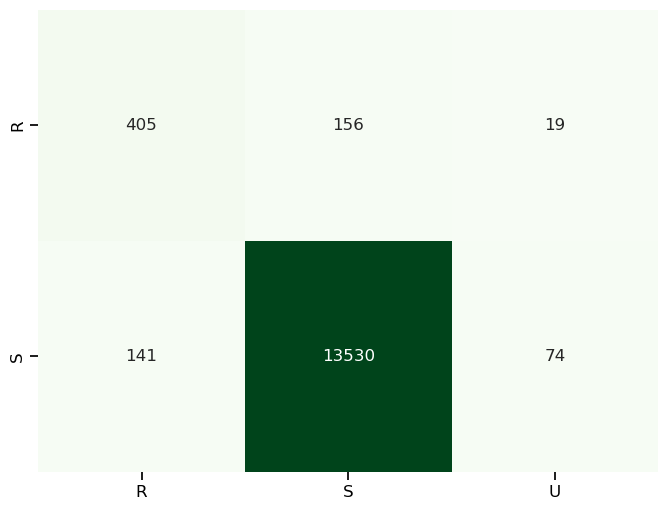

In [ ]:
# Build catalogue
catalogue_01 = BuildCatalogue(samples, cat_mutations, 0.10)
catalogue_01_df = (
    pd.DataFrame.from_dict(catalogue_01.return_catalogue(), orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)

#save catalogue file
catalogue_01.return_piezo(
    "NC_000962.3", "BDQ-FRS-10-2023.11", "1.1", "BDQ", piezo_wildcards
).to_csv("./catalogues/catalogue_FRS_10.csv", index=False)

# Predict with catalogue
cm = piezo_predict(all, "./catalogues/catalogue_FRS_10.csv", "BDQ")["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Alice used 2 reads - but used variants that they were very confident wtr to resistance, so could use a very low FRS. We are being a little more conservative (particularly with respect to pseudo-heursitc, were only one instance will be allowed in). But could go lower iwth a bigger better dataset.



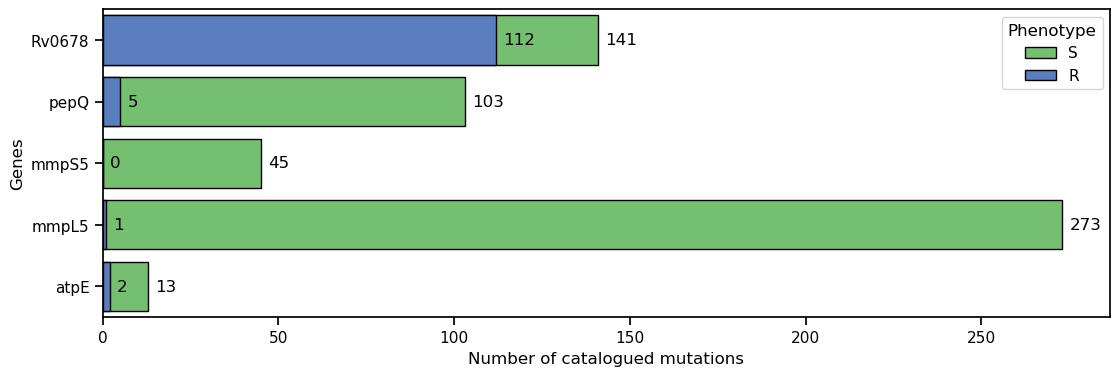

In [ ]:
Helpers.plot_catalogue_counts_h(all, catalogue_01_df)

In [ ]:
# Record false positives
predicted_R = all[
    all.GENE_MUT.isin(catalogue_01_df[catalogue_01_df.PHENOTYPE == "R"].MUTATION)
].UNIQUEID.unique()
fp_df = all[(all.UNIQUEID.isin(predicted_R)) & (all.PHENOTYPE == "S")]
fp_ids = fp_df.UNIQUEID.unique()

### Plot sensitivty and specificity at varying FRS thresholds

In [ ]:
sns.set_context("notebook")

sens, spec, cov = [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue
    BuildCatalogue(samples, cat_mutations, i).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2023.11", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/catalogue_FRS_{i*100}.csv", index=False)
    #predict with catalogue
    cm = piezo_predict(all, f"./catalogues/catalogue_FRS_{i*100}.csv", "BDQ", Print=False)["cm"]
    sens.append(cm[0][0] / (cm[0][0] + cm[0][1]))
    spec.append(cm[1][1] / (cm[1][1] + cm[1][0]))
    cov.append((len(samples) - cm[0][2] - cm[1][2]) / len(samples))
    FRS.append(i)

data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov}
)

[[  405   156    19]
 [  141 13530    74]]
Catalogue coverage of isolates: 0.9935078534031414
Sensitivity: 0.7219251336898396
Specificity: 0.9896861970594689
[[  408   154    18]
 [  143 13526    76]]
Catalogue coverage of isolates: 0.9934380453752182
Sensitivity: 0.7259786476868327
Specificity: 0.9895383714975492
[[  409   154    17]
 [  144 13529    72]]
Catalogue coverage of isolates: 0.9937870855148342
Sensitivity: 0.7264653641207816
Specificity: 0.9894682951802823
[[  405   156    19]
 [  143 13526    76]]
Catalogue coverage of isolates: 0.993368237347295
Sensitivity: 0.7219251336898396
Specificity: 0.9895383714975492
[[  405   156    19]
 [  143 13524    78]]
Catalogue coverage of isolates: 0.9932286212914485
Sensitivity: 0.7219251336898396
Specificity: 0.9895368405648642
[[  402   158    20]
 [  142 13526    77]]
Catalogue coverage of isolates: 0.9932286212914485
Sensitivity: 0.7178571428571429
Specificity: 0.9896107696810067
[[  387   171    22]
 [  131 13535    79]]
Catalogue 

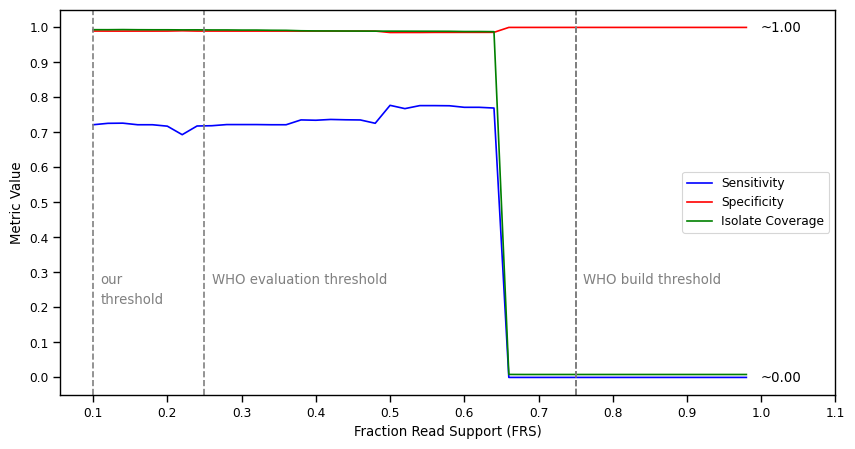

In [ ]:
# Create a line plot using seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x="FRS", y="Sensitivity", data=data, label="Sensitivity", color="blue")
sns.lineplot(x="FRS", y="Specificity", data=data, label="Specificity", color="red")
sns.lineplot(x="FRS", y="Coverage", data=data, label="Isolate Coverage", color="green")

yticks = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1,
]  # Your custom y-tick values
xticks = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1.0,
    1.1,
]  # Your custom y-tick values

plt.yticks(yticks)
plt.xticks(xticks)

# Add labels and legend
plt.xlabel("Fraction Read Support (FRS)")
plt.ylabel("Metric Value")
plt.legend(loc="best")

# Add final values at the end of each line
for line in plt.gca().lines[:-1]:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    final_value = y_data[-1]
    plt.annotate(
        f"~{final_value:.2f}",
        (x_data[-1], final_value),
        textcoords="offset points",
        xytext=(25, -3),
        ha="center",
    )

    plt.axvline(x=0.75, color="gray", linestyle="--", label="FRS=0.75")

plt.axvline(x=0.75, color="gray", linestyle="--", label="FRS=0.75")
plt.text(0.76, 0.3, "WHO build threshold", color="gray", ha="left", va="top")

plt.axvline(x=0.25, color="gray", linestyle="--", label="FRS=0.25")
plt.text(0.26, 0.3, "WHO evaluation threshold", color="gray", ha="left", va="top")

plt.axvline(x=0.1, color="gray", linestyle="--", label="FRS=0.1")
plt.text(0.11, 0.3, "our", color="gray", ha="left", va="top")
plt.text(0.11, 0.24, "threshold", color="gray", ha="left", va="top")


# Show the plot
plt.show()

### Cross validation at FRS=0.1, and 0.9 (supplementary figures)

FRS = 0.90

[[   0    0  116]
 [   0   19 2730]]
Catalogue coverage of isolates: 0.006631762652705061
Sensitivity: nan
Specificity: 1.0
[[  72   22   23]
 [  42 2600  106]]
Catalogue coverage of isolates: 0.9549738219895288
Sensitivity: 0.7659574468085106
Specificity: 0.9841029523088569
[[   0    1  105]
 [   0   23 2736]]
Catalogue coverage of isolates: 0.008376963350785341
Sensitivity: 0.0
Specificity: 1.0
[[   0    1  126]
 [   0   20 2718]]
Catalogue coverage of isolates: 0.007329842931937173
Sensitivity: 0.0
Specificity: 1.0
[[   0    1  119]
 [   0   21 2724]]
Catalogue coverage of isolates: 0.007678883071553229
Sensitivity: 0.0
Specificity: 1.0
isolate_cov (0.19699825479930191, 0.3789882014915321)
specificity (0.9968205904617713, 0.006358819076457235)
sensitivity (nan, nan)


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

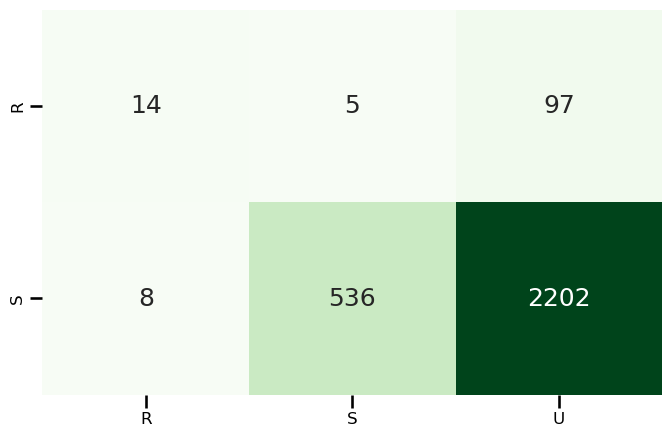

In [ ]:
FRS = 0.9
#Build and prediction steps are wrapped in piezo_predict_cv 
df_cm, labels = piezo_predict_cv(
    all,
    samples,
    cat_mutations,
    FRS,
    5,
    0.2,
    7,
    "NC_000962.3",
    f"BDQ-FRS-{FRS}-2023.11_cv",
    "1.1",
    "BDQ",
    piezo_wildcards,
)

sns.set_context("talk")
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, annot=labels, cbar=False, cmap="Greens", fmt="")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

FRS = 0.10

[[  67   27   22]
 [  46 2600  103]]
Catalogue coverage of isolates: 0.956369982547993
Sensitivity: 0.7127659574468085
Specificity: 0.982615268329554
[[  57   39   21]
 [  33 2619   96]]
Catalogue coverage of isolates: 0.9591623036649215
Sensitivity: 0.59375
Specificity: 0.9875565610859729
[[  56   33   17]
 [  34 2625  100]]
Catalogue coverage of isolates: 0.9591623036649215
Sensitivity: 0.6292134831460674
Specificity: 0.9872132380594209
[[  72   24   31]
 [  37 2591  110]]
Catalogue coverage of isolates: 0.9507853403141361
Sensitivity: 0.75
Specificity: 0.9859208523592086
[[  58   39   23]
 [  33 2604  108]]
Catalogue coverage of isolates: 0.9542757417102967
Sensitivity: 0.5979381443298969
Specificity: 0.987485779294653
isolate_cov (0.9559511343804538, 0.0031714671390158824)
specificity (0.9861583398257618, 0.0018676019085160074)
sensitivity (0.6567335169845546, 0.06327628743540761)


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

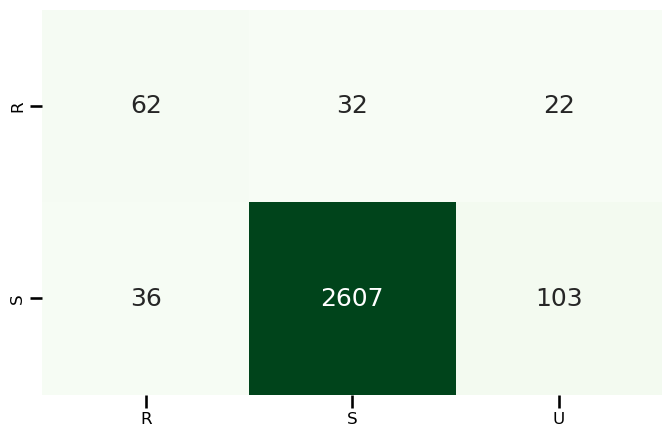

In [ ]:
FRS = 0.1

df_cm, labels = piezo_predict_cv(
    all,
    samples,
    cat_mutations,
    FRS,
    5,
    0.2,
    7,
    "NC_000962.3",
    f"BDQ-FRS-{FRS}-2023.11_cv",
    "1.1",
    "BDQ",
    piezo_wildcards,
)

sns.set_context("talk")
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, annot=labels, cbar=False, cmap="Greens", fmt="")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Our method is performing well using FRS thresholds of 0.65 and below, however the vast majority of mmpL5 variants are catalogued as susceptible (249/250), which would suggest mmpL5 does not contirbute to resistance against BDQ. Therefore should be able to remove it with little effect on performance

## Remove mmpL5, rebuild  catalogue and predict

I see several ways to do this. Build catalogue without mmpL5. The validate on a dataset with mmpL5 removed (which will remove a lot of samples). Or validate on the same samples as before, but make mmpL5 mutations wildtype or synonymous

In [ ]:
mutations_no_mmpL5 = cat_mutations[cat_mutations.GENE != "mmpL5"]

In [ ]:
gene_mut_no_mmpL5 = []
for i in all.index:
    if all['GENE'][i]=='mmpL5': 
        #make all mmpL5 mutations synonymous so piezo automatically call them S
        gene_mut_no_mmpL5.append('mmpL5@A1A')
    else:
        gene_mut_no_mmpL5.append(all['GENE_MUT'][i])
all_WT_mmpL5 = all.copy()
all_WT_mmpL5['GENE_MUT'] = gene_mut_no_mmpL5
all_WT_mmpL5

#Say something about 'made model treat every mmpL5 mutation as susceptible' (don't mention making synonymous)
#should probably do 2 runs, one without mmpL5 even in test set, and the other with all mutations but predicting them as S

,UNIQUEID,DRUG,PHENOTYPE,METHOD_MIC,Unnamed: 0,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,...,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUT,IS_SYNONYMOUS
0,site.01.subj.DR0134.lab.DR0134.iso.1,BDQ,S,0.06,3729.0,mmpL5,T794I,acc,atc,NaN,...,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5@A1A,False
1,site.01.subj.DR0134.lab.DR0134.iso.1,BDQ,S,0.06,3730.0,mmpL5,I948V,att,gtt,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False
2,site.01.subj.DR0611.lab.DR0611.iso.1,BDQ,S,0.015,7717.0,mmpL5,I948V,att,gtt,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False
3,site.01.subj.DR0602.lab.DR0602.iso.1,BDQ,S,<=0.008,13624.0,Rv0678,c-11a,c,a,-11.0,...,NaN,NaN,NaN,NaN,1.0,False,NaN,1.0,Rv0678@c-11a,False
4,site.01.subj.DR0602.lab.DR0602.iso.1,BDQ,S,<=0.008,14122.0,mmpL5,D767N,gac,aac,NaN,...,NaN,NaN,767.0,N,1.0,False,NaN,1.0,mmpL5@A1A,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31716,site.14.subj.1590.lab.1590.iso.1,BDQ,S,0.12,40777728.0,pepQ,G197R,ggg,agg,NaN,...,NaN,NaN,197.0,R,1.0,False,NaN,1.0,pepQ@G197R,False
31717,site.14.subj.4200.lab.4200.iso.1,BDQ,S,0.06,40777984.0,mmpL5,T794I,acc,atc,NaN,...,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5@A1A,False
31718,site.14.subj.4200.lab.4200.iso.1,BDQ,S,0.06,40777985.0,mmpL5,I948V,att,gtt,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False
31719,site.14.subj.4395.lab.4395.iso.1,BDQ,S,0.015,40779573.0,mmpL5,I948V,att,gtt,NaN,...,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5@A1A,False


[[  426   134    20]
 [  148 13491   106]]
Catalogue coverage of isolates: 0.9912041884816754
Sensitivity: 0.7607142857142857
Specificity: 0.9891487645721827


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

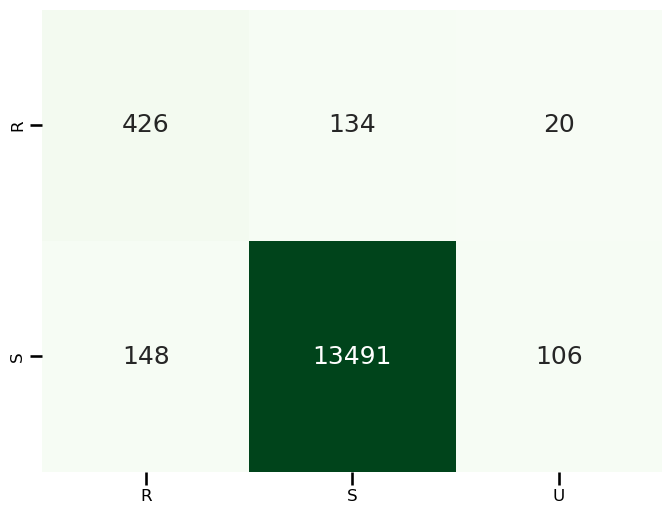

In [ ]:
#Build catalogue with mmpL5's predicted as S/treated as not relevant
catalogue_01_no_mmpL5 = BuildCatalogue(samples, mutations_no_mmpL5, 0.1)
catalogue_01_no_mmpL5_df = (
    pd.DataFrame.from_dict(catalogue_01_no_mmpL5.return_catalogue(), orient="index")
    .reset_index(0)
    .rename(columns={"index": "MUTATION"})
)
#save catalogue file
catalogue_01_no_mmpL5.return_piezo(
    "NC_000962.3", "BDQ-FRS-10-2023.11-rm-mmpL5", "1.1", "BDQ", piezo_wildcards
).to_csv("./catalogues/rem_mmpL5/catalogue_FRS_10_rm_mmpL5.csv", index=False)

#predict with catalogue
cm = piezo_predict(
    all_WT_mmpL5, "./catalogues/rem_mmpL5/catalogue_FRS_10_rm_mmpL5.csv",'BDQ'
)["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Assume its S to start. Any missesne mutations at any position is a S. Then R > U > S. Build a catalogue that Piezo understands and feed it to Piezo to make prediction. Then can reference the catalogues we have made in a form thats accessible with Piezo. Also, join genomes and phenotypes, and do left join with mutations --> that'll give 'WTs' (assumed to be susceptible)

In [ ]:
# Record false positives
predicted_R_no_mmpL5 = all_WT_mmpL5[
    all_WT_mmpL5.GENE_MUT.isin(
        catalogue_01_no_mmpL5_df[catalogue_01_no_mmpL5_df.PHENOTYPE == "R"].MUTATION
    )
].UNIQUEID.unique()
fp_df_no_mmpL5 = all_WT_mmpL5[
    (all_WT_mmpL5.UNIQUEID.isin(predicted_R_no_mmpL5)) & (all_WT_mmpL5.PHENOTYPE == "S")
]
fp_ids_no_mmpL5 = fp_df_no_mmpL5.UNIQUEID.unique()


#How many of the false positives are shared with those when mmpL5 was included?
overlap = [fp for fp in fp_ids if fp in fp_ids_no_mmpL5]
len(overlap)

136

Removing mmpL5 achieves a significant increase in sensitivity, but at the cost of a drop in specificity. However, this drop is not surprising given how many susceptible samples we have lost, and 130/146 of the false positives are the same as those when mmpL5 was included.

## Is there any correlation between FRS and MIC?

In [ ]:
sns.set_context("notebook")

all["MIC_FLOAT"] = Helpers.mic_to_float(all["METHOD_MIC"].tolist())


R_muts = catalogue_01_df[catalogue_01_df.PHENOTYPE == "R"].MUTATION.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.GENE_MUT.isin(R_muts))]) == 1:
        solo_Rs.append(i)

df = pd.DataFrame.from_dict(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in np.log2(
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)
df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]

df = df[df.MIC >= 0]
df["MIC"] = [str(i) for i in df.MIC]

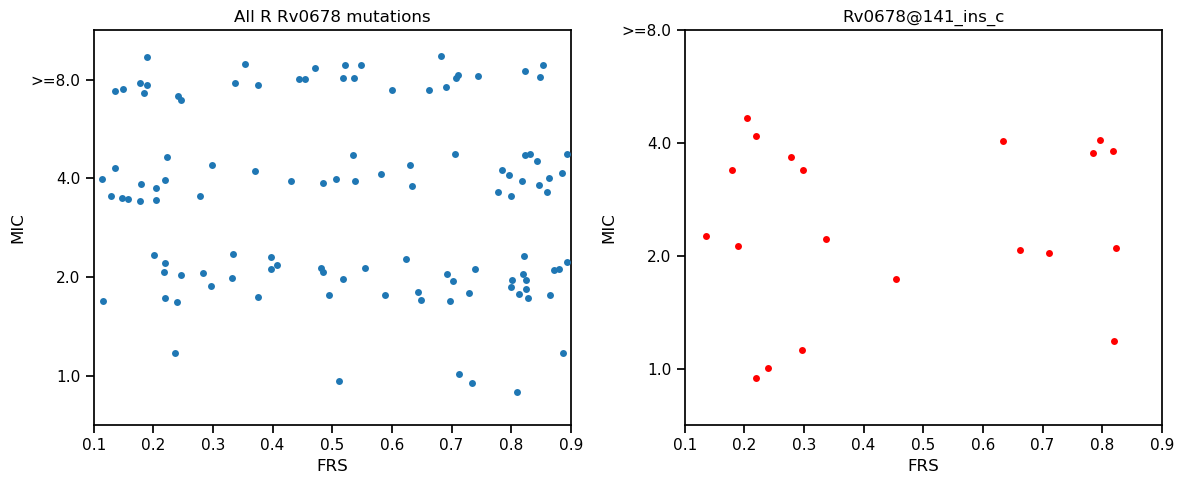

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.stripplot(x="FRS", y="MIC", data=df[df.FRS < 0.9], ax=axes[0], jitter=0.25)
axes[0].set_title("All R Rv0678 mutations")
axes[0].invert_yaxis()
axes[0].set_yticks([0, 1, 2, 3], labels=[1.0, 2.0, 4.0, ">=8.0"])
axes[0].set_xlim(0.1, 0.9)


sns.stripplot(
    x="FRS",
    y="MIC",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    jitter=0.25,
    color="red",
)
axes[1].set_title("Rv0678@141_ins_c")
axes[1].set_yticks([0, 1, 2, 3], labels=[1.0, 2.0, 4.0, ">=8.0"])
axes[1].set_xlim(0.1, 0.9)  # Set x-axis range
axes[1].invert_yaxis()


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

There is no correlation between FRS and MIC for Rv0678 resistant variants generally, as well as for the most variable (wrt FRS) mutations in Rv0678. This would suggest there is no effective fitness cost resulting from Rv0678 resistant mutations, as minor resistant populations can rapidly outcompete major WT populations. It would be interesting to analyse growth data from the plates, however this data is not available.

## Is there any correlation between FRS and growth?

In [ ]:
growth_dil = growth[(growth.DILUTION.isin([1, 2, 3])) & (growth.READINGDAY == 14)]
# subset growth data to dilutions of 1, 2, or 3 fold so there is drug present, and only look at groth at 14 days post incubation
growth_dil = growth_dil[["UNIQUEID", "GROWTH"]].groupby("UNIQUEID").mean()
# average growth across dilutions
growth_dil

,GROWTH
UNIQUEID,
site.01.subj.DR0013.lab.DR0013.iso.1,13.239288
site.01.subj.DR0018.lab.DR0018.iso.1,35.075825
site.01.subj.DR0025.lab.DR0025.iso.1,14.489963
site.01.subj.DR0030.lab.DR0030.iso.1,41.714438
site.01.subj.DR0031.lab.DR0031.iso.1,4.745861
...,...
site.20.subj.SCH8604398.lab.YA00134621.iso.1,20.066556
site.20.subj.SCH8604399.lab.YA00134971.iso.1,19.883464
site.20.subj.SCH8608291.lab.YA00135762.iso.1,11.091854


In [ ]:
df = pd.merge(growth_dil, cat_mutations[cat_mutations.GENE=='Rv0678'], how='inner', on='UNIQUEID')
#filter for samples with only a single resistant mutation (and however many S)
df = df[df.UNIQUEID.isin(solo_Rs)]

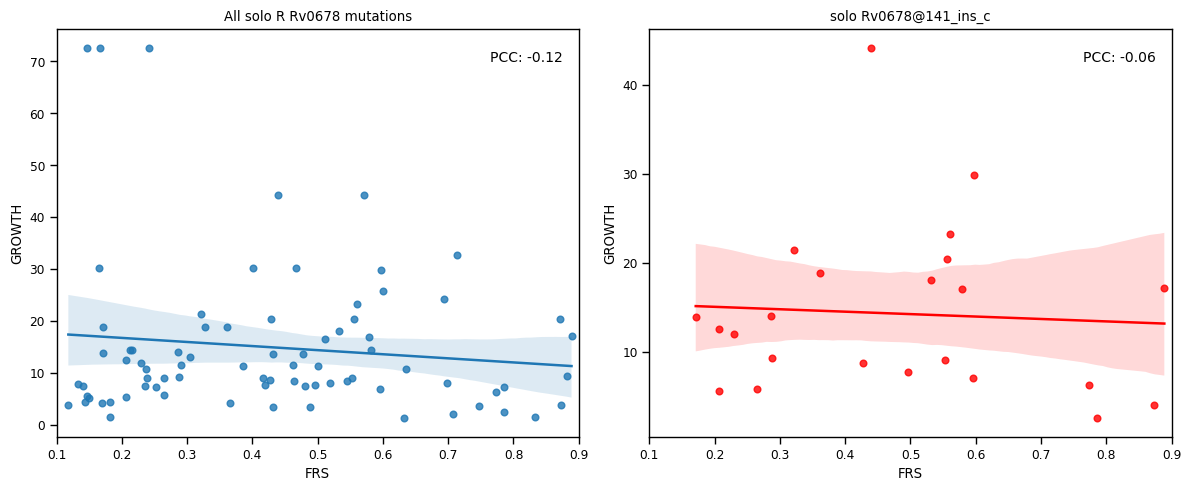

In [ ]:
sns.set_context("paper")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.regplot(x="FRS", y="GROWTH", data=df[df.FRS < 0.9], ax=axes[0], ci=95)
axes[0].set_title("All solo R Rv0678 mutations")
axes[0].set_xlim(0.1, 0.9)

# Calculate Pearson correlation coefficient
pcc_value = df[df.FRS < 0.9][["FRS", "GROWTH"]].corr().iloc[0, 1]

# Annotate the first subplot with the PCC value
axes[0].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


sns.regplot(
    x="FRS",
    y="GROWTH",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    color="red",ci=95
)
axes[1].set_title("solo Rv0678@141_ins_c")
axes[1].set_xlim(0.1, 0.9)  # Set x-axis range

# Calculate Pearson correlation coefficient
pcc_value = (
    df[(df.FRS < 0.9) & (df.GENE_MUT == "Rv0678@141_ins_c")][["FRS", "GROWTH"]]
    .corr()
    .iloc[0, 1]
)

# Annotate the first subplot with the PCC value
axes[1].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


# Adjust layout
plt.tight_layout()

# Show the plot